<a href="https://colab.research.google.com/github/pachterlab/BBB/blob/master/notebooks/lung_atlas/mouse_lung_dropseq_SRR8426358_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bioinformatics for Benched Biologists
This Python notebook pre-processes [tissue from the whole mouse lung](https://www.ncbi.nlm.nih.gov/sra?term=SRX5234128) from [Ilias Angelidis, Lukas M. Simon et al. 2019](https://www.nature.com/articles/s41467-019-08831-9) with kallisto and bustools using `kb`, and then performs an analysis of the cell types and their marker genes.

The notebook was written by A. Sina Booeshaghi and Lior Pachter and is based on three noteboks:
- The kallisto | bustools [Introduction to single-cell RNA-seq I](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_1_minute_intro.ipynb#scrollTo=wtwMjIjjCMcD) notebook.
- The kallisto | bustools [Introduction to single-cell RNA-seq II](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_standard.ipynb#scrollTo=ijU_u6uj3Sio) notebook.
- The Scanpy [Preprocessing and clustering 3k PBMCs" notebook](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Wolf, F. A., Angere, P. and Theis, F.J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biology (2018). doi:10.1186/s13059-017-1382-0


## Setup

In [0]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [2]:
%%time
# These packages are pre-installed on Google Colab, but are included here to simplify running this notebook locally
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
!pip install leidenalg
!pip install scanpy

     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 3.2MB 16.3MB/s 
  Created wheel for leidenalg: filename=leidenalg-0.7.0-cp36-cp36m-linux_x86_64.whl size=1107368 sha256=c51348fcf53235b4491eff2c94be6789ccdca0c4246e107a9e11725de3505713
  Stored in directory: /root/.cache/pip/wheels/29/55/48/5a04693a10f50297bcda23819ca23ab3470a61dd911851c8bd
Successfully built leidenalg
     |████████████████████████████████| 7.2MB 3.4MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 2.9MB 40.2MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninst

### Install kb-python

In [3]:
%%time
# install kb
!pip install kb-python 

     |████████████████████████████████| 35.4MB 95kB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=c5f34652caf97069f5ff6d34d99e794c00c9a50a8731eaa070f608928d2871fb
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28042 sha256=92ff675c04148b3e4475637ccd13778989b3ec84fa890fa0356e7fcb8480594f
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built loompy numpy-groupies
CPU times: user 292 ms, sys: 81.5 ms, total: 374 ms
Wall time: 10.4 s


### Download the data

In [4]:
%%time
# Download the data from the ENA https://www.ebi.ac.uk/ena/browser/view/SRR8426358
# !wget --continue ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_1.fastq.gz
# !wget --continue ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_2.fastq.gz


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


### Download an index

This data consists of cells from a mouse lung, so we download the mouse index.

In [5]:
!kb ref -d mouse -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2020-03-24 04:53:57,348]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2020-03-24 04:55:11,743]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz


## Pseudoalignment and counting

### Run kallisto and bustools

In [0]:
# %%time
# !kb count --h5ad -i index.idx -g t2g.txt -x Dropseq -o output --filter bustools -t 2 \
# SRR8426358_1.fastq.gz \
# SRR8426358_2.fastq.gz

In [7]:
%%time
!kb count --h5ad -i index.idx -g t2g.txt -x Dropseq -o output --filter bustools -t 2 \
ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_1.fastq.gz \
ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_2.fastq.gz

[2020-03-24 04:55:44,896]    INFO Piping ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_1.fastq.gz to tmp/SRR8426358_1.fastq.gz
[2020-03-24 04:55:44,898]    INFO Piping ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_2.fastq.gz to tmp/SRR8426358_2.fastq.gz
[2020-03-24 04:55:44,898]    INFO Generating BUS file from
[2020-03-24 04:55:44,899]    INFO         tmp/SRR8426358_1.fastq.gz
[2020-03-24 04:55:44,899]    INFO         tmp/SRR8426358_2.fastq.gz
[2020-03-24 05:14:57,316]    INFO Sorting BUS file output/output.bus to tmp/output.s.bus
[2020-03-24 05:15:18,683]    INFO Whitelist not provided
[2020-03-24 05:15:18,683]    INFO Generating whitelist output/whitelist.txt from BUS file tmp/output.s.bus
[2020-03-24 05:15:18,767]    INFO Inspecting BUS file tmp/output.s.bus
[2020-03-24 05:15:20,706]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist output/whitelist.txt
[2020-03-24 05:15:21,400]    INFO Sorting BUS fi

## Basic QC

In [0]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [0]:
# load the unfiltered matrix
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

In [10]:
adata

AnnData object with n_obs × n_vars = 3362 × 55421 
    var: 'gene_id', 'gene_name'

# Populate the anndata

In [0]:
# Important constants we will use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

n_top_genes = 5000

n_bins = 20

flavor="seurat"

In [0]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

## Observe features of anndata

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

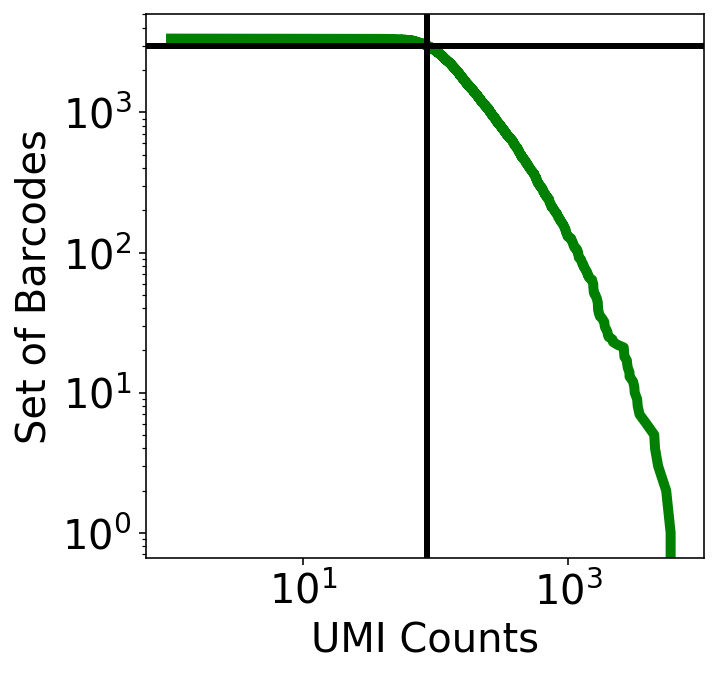

In [13]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells = 3000#@param {type:"integer"}
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

### Examine the saturation of the library

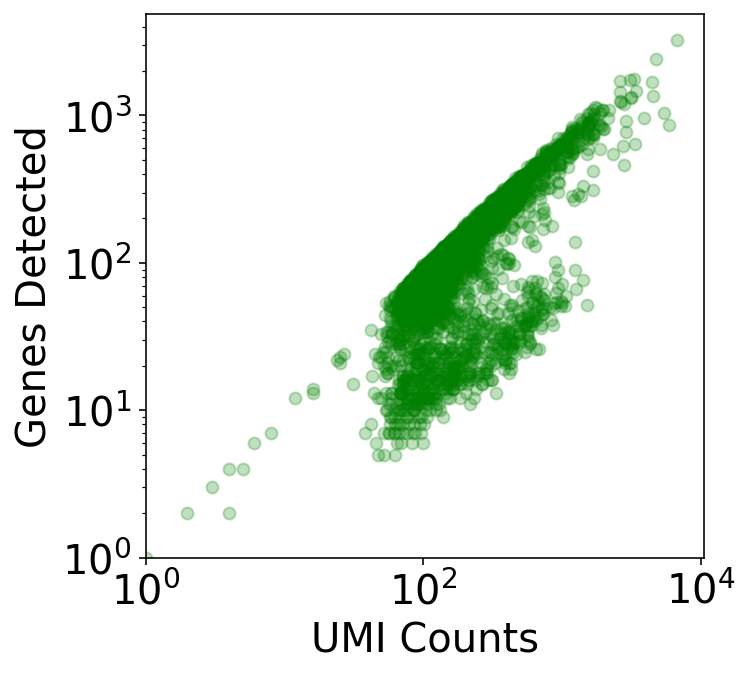

In [14]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(5, 5))

x = nd(adata.X.sum(axis=1))
y = nd(np.sum(adata.X>0, axis=1))

ax.scatter(x, y, color="green", alpha=0.25)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)

plt.show()

This plot is very misleading, as even the small alpha can't accurately show how many points are stacked at one location (This takes about a minute to run since there are a lot of points)

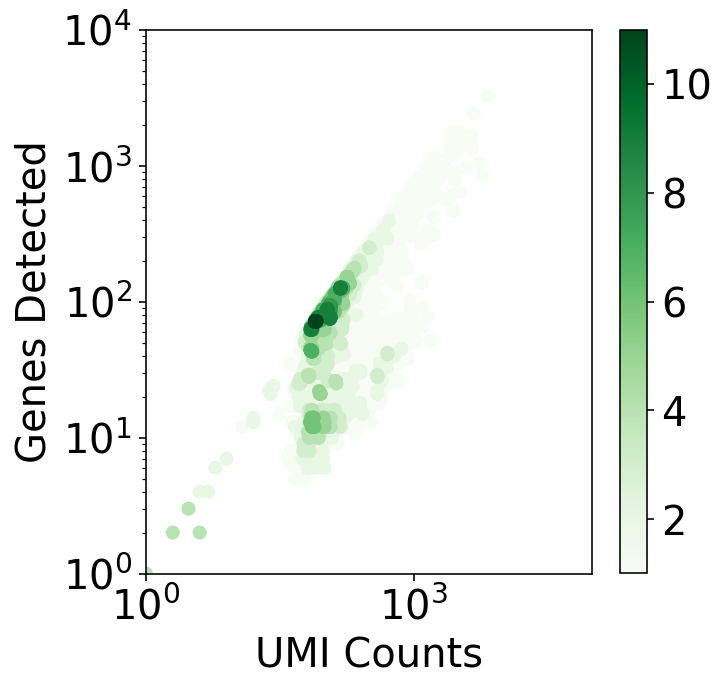

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

### Examine the mitochondrial content per cell

It is useful to examine mitochondrial genes, which are important for quality control. [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics) write that

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

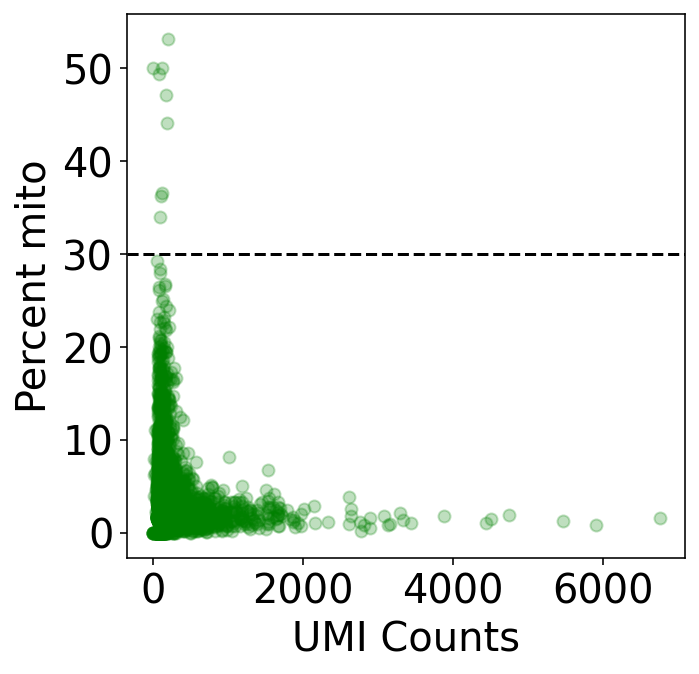

In [16]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(adata.obs["cell_counts"])
y = nd(adata.obs["percent_mito"])

ax.scatter(x, y, color="green", alpha=0.25)

ax.axhline(y=mito_criteria, linestyle="--", color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")

plt.show()

## Filter the anndata

In [0]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [0]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

In [19]:
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 3,362 cells x 55,421 genes
    New shape: 2,725 cells x 12,515 genes


In [0]:
data = adata[cell_mask, gene_mask]

In [21]:
data

View of AnnData object with n_obs × n_vars = 2725 × 12515 
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'pass_gene_filter'

Keep in mind that the values in the `obs` and `var` are from the pre-filtered adata.

## Analysis

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

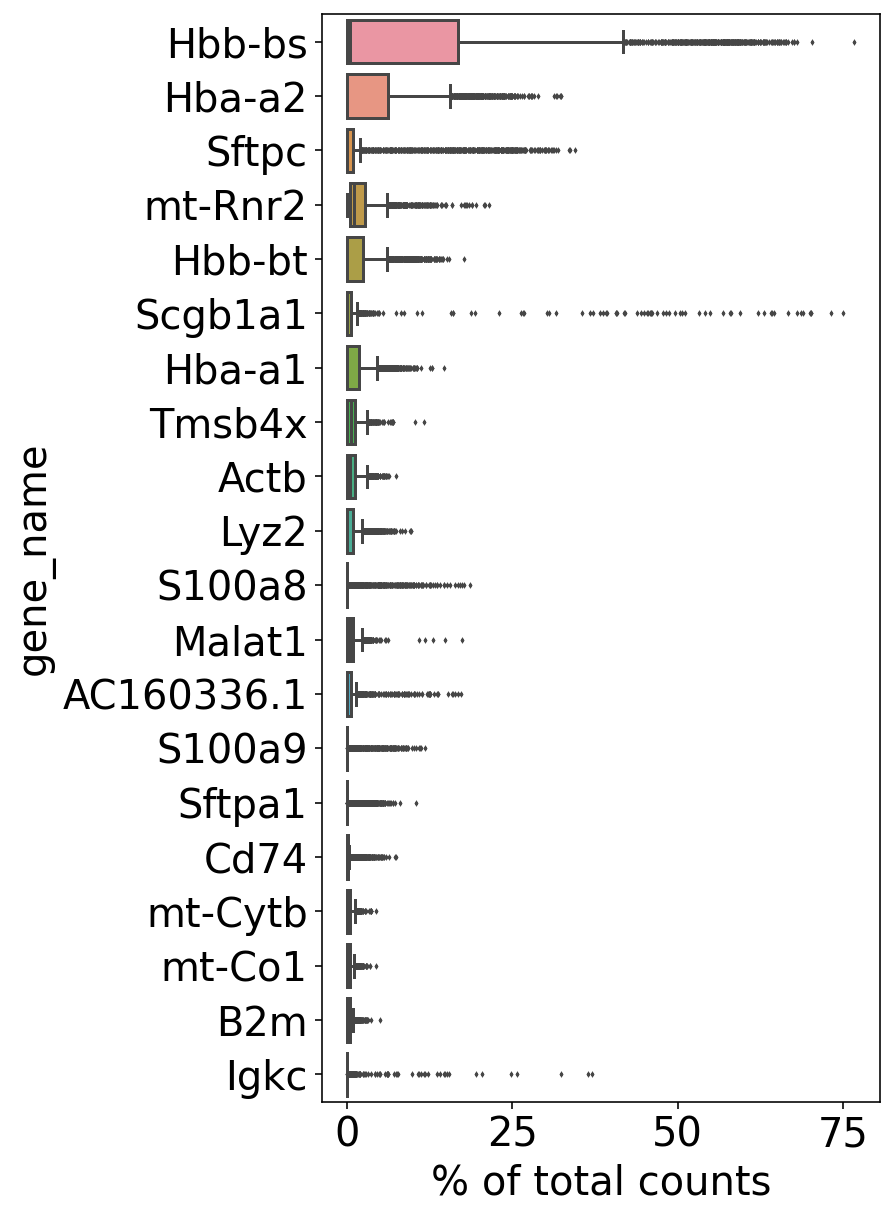

In [22]:
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(data, n_top=20, ax = ax)

In [0]:
def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    return ax

Plot distributions

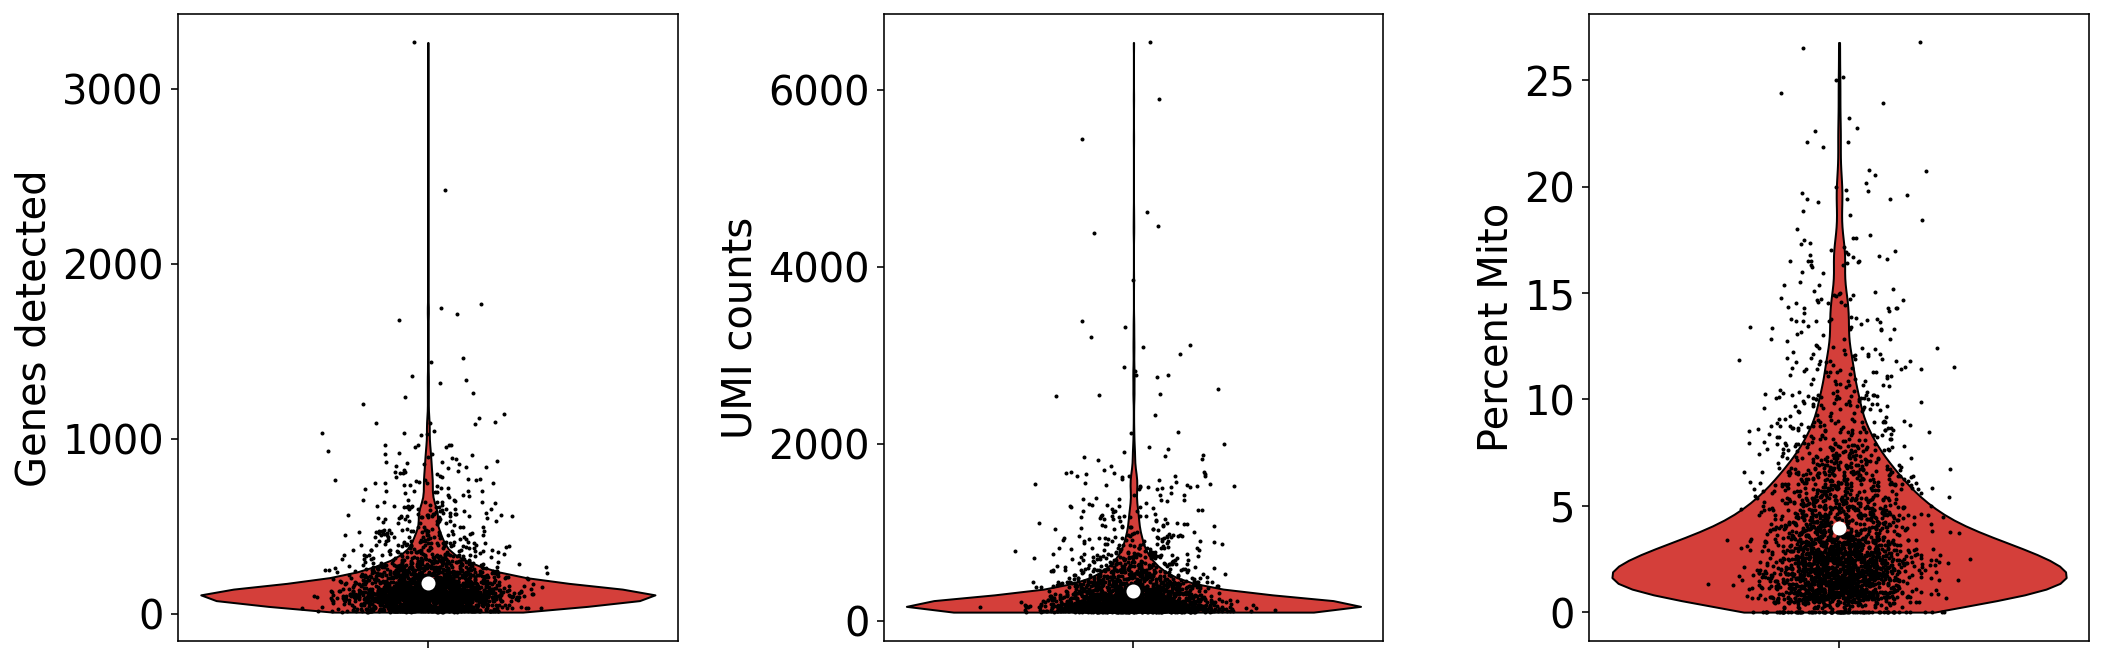

In [24]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)

x1 = data.obs["n_genes"]
x2 = nd(data.X.sum(axis=1))
x3 = data.obs["percent_mito"]

vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])

ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")

plt.tight_layout()
plt.show()

# Process the matrix for clustering, visualization, and DE

In [0]:
data.layers["raw"] = data.X

In [0]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [0]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [0]:
data.X = data.layers["log1p"]

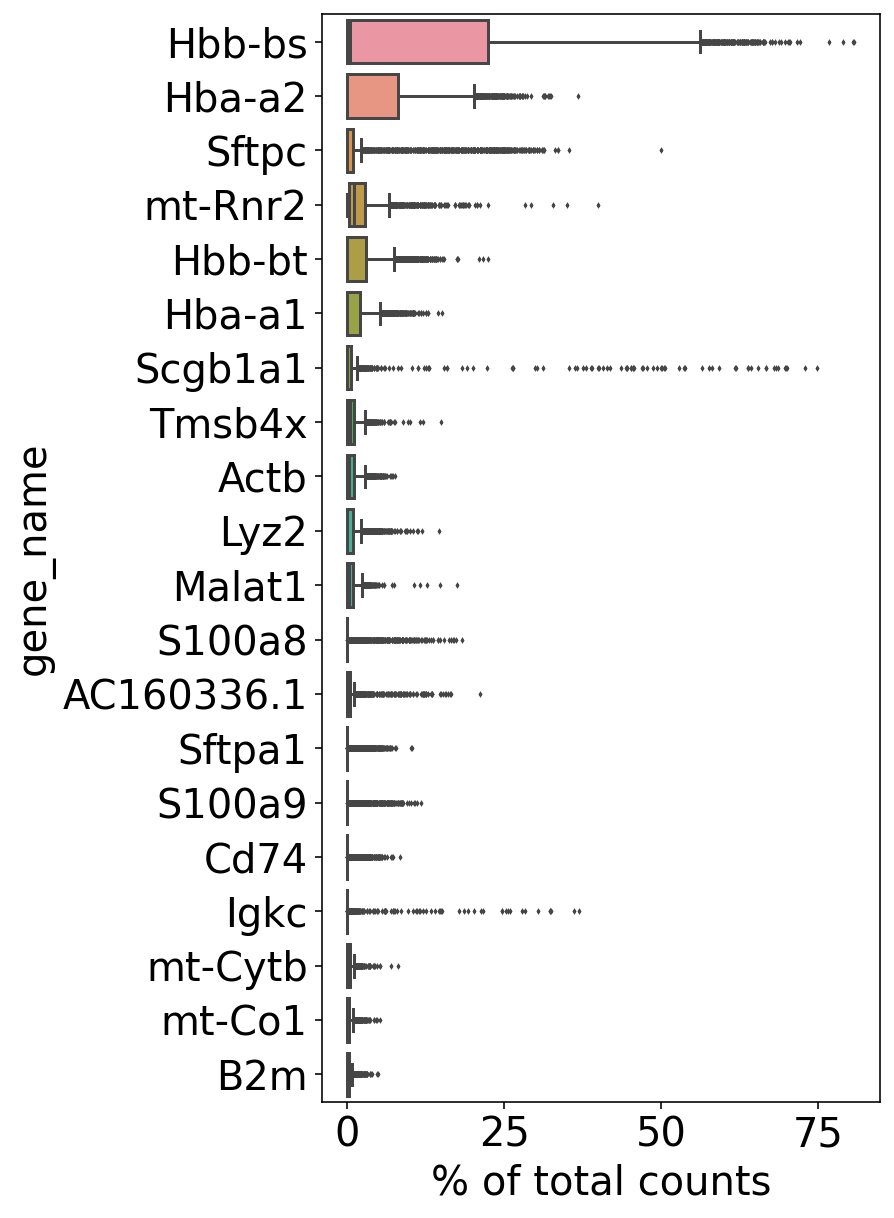

In [29]:
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(adata, n_top=20, ax=ax)

Detecting highly variable genes is done on the log1p(norm) data

In [0]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values

Now we scale the columns of the matrix to unit variance and zero mean

In [31]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"].todense()
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
data.X = data.layers["scale"]

del mat

CPU times: user 934 ms, sys: 68.3 ms, total: 1 s
Wall time: 1 s


# Generating visualizations

## PCA on highly variable genes

In [32]:
%%time
# PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

CPU times: user 1.86 s, sys: 134 ms, total: 2 s
Wall time: 1.06 s


## Clustering

In [0]:
sc.pp.neighbors(data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

In [0]:
sc.tl.leiden(data, random_state=state)

## Dimensionality reduction

In [0]:
# TSNE
X = data.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_pca_tsne"] = tsne.fit_transform(X)

In [0]:
# NCA
X = data.X
y = data.obs.leiden.values # you could use louvain here also

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
data.obsm["X_nca"] = nca.fit_transform(X, y)

In [0]:
# TSNE the NCA
X = data.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_nca_tsne"] = tsne.fit_transform(X)

# Visualize

## TSNE of PCA

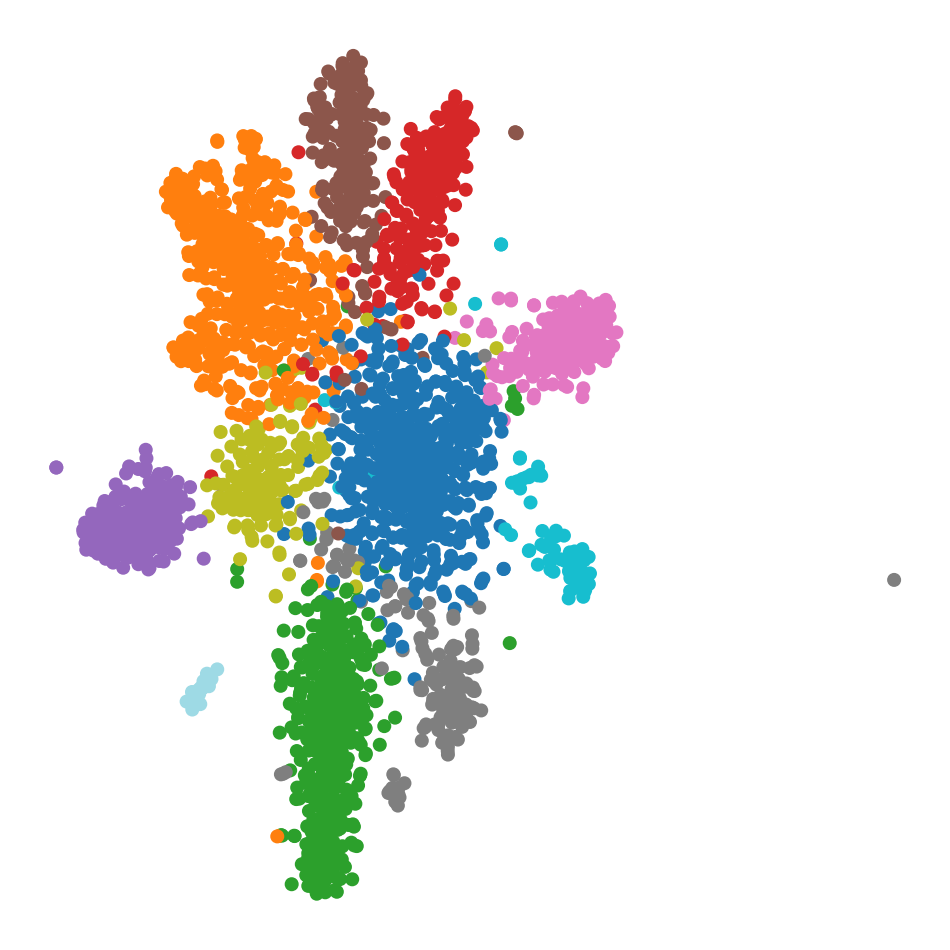

In [38]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_pca_tsne"][:,0]
y = data.obsm["X_pca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()

## TSNE of NCA

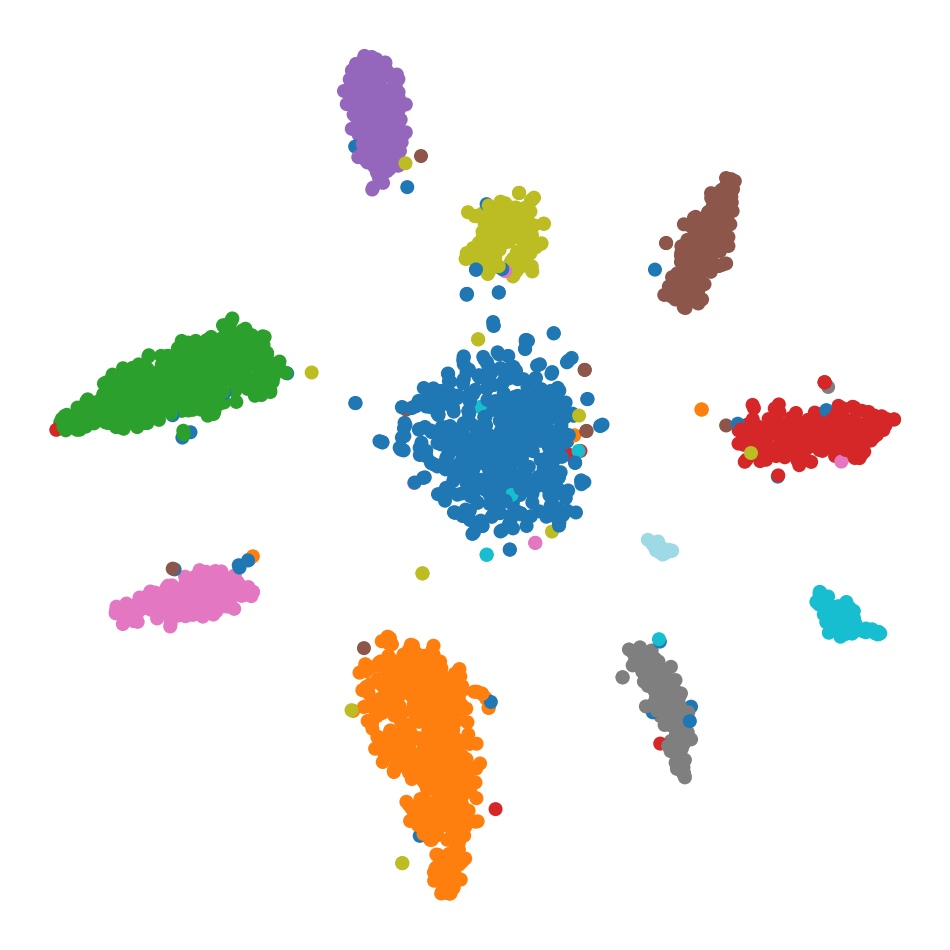

In [39]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()

### Find marker genes

A key aspect of annotating a cell atlas is identifying "marker genes". These are genes specific to individual clusters that "mark" them, and are important both for assigning functions to cell clusters, and for designing downstream experiments to probe activity of clusters. 

A gene marker analysis begins with ranking genes in each cluster according to how different they are relative to other clusters. Typically the t-test is used for this purpose.

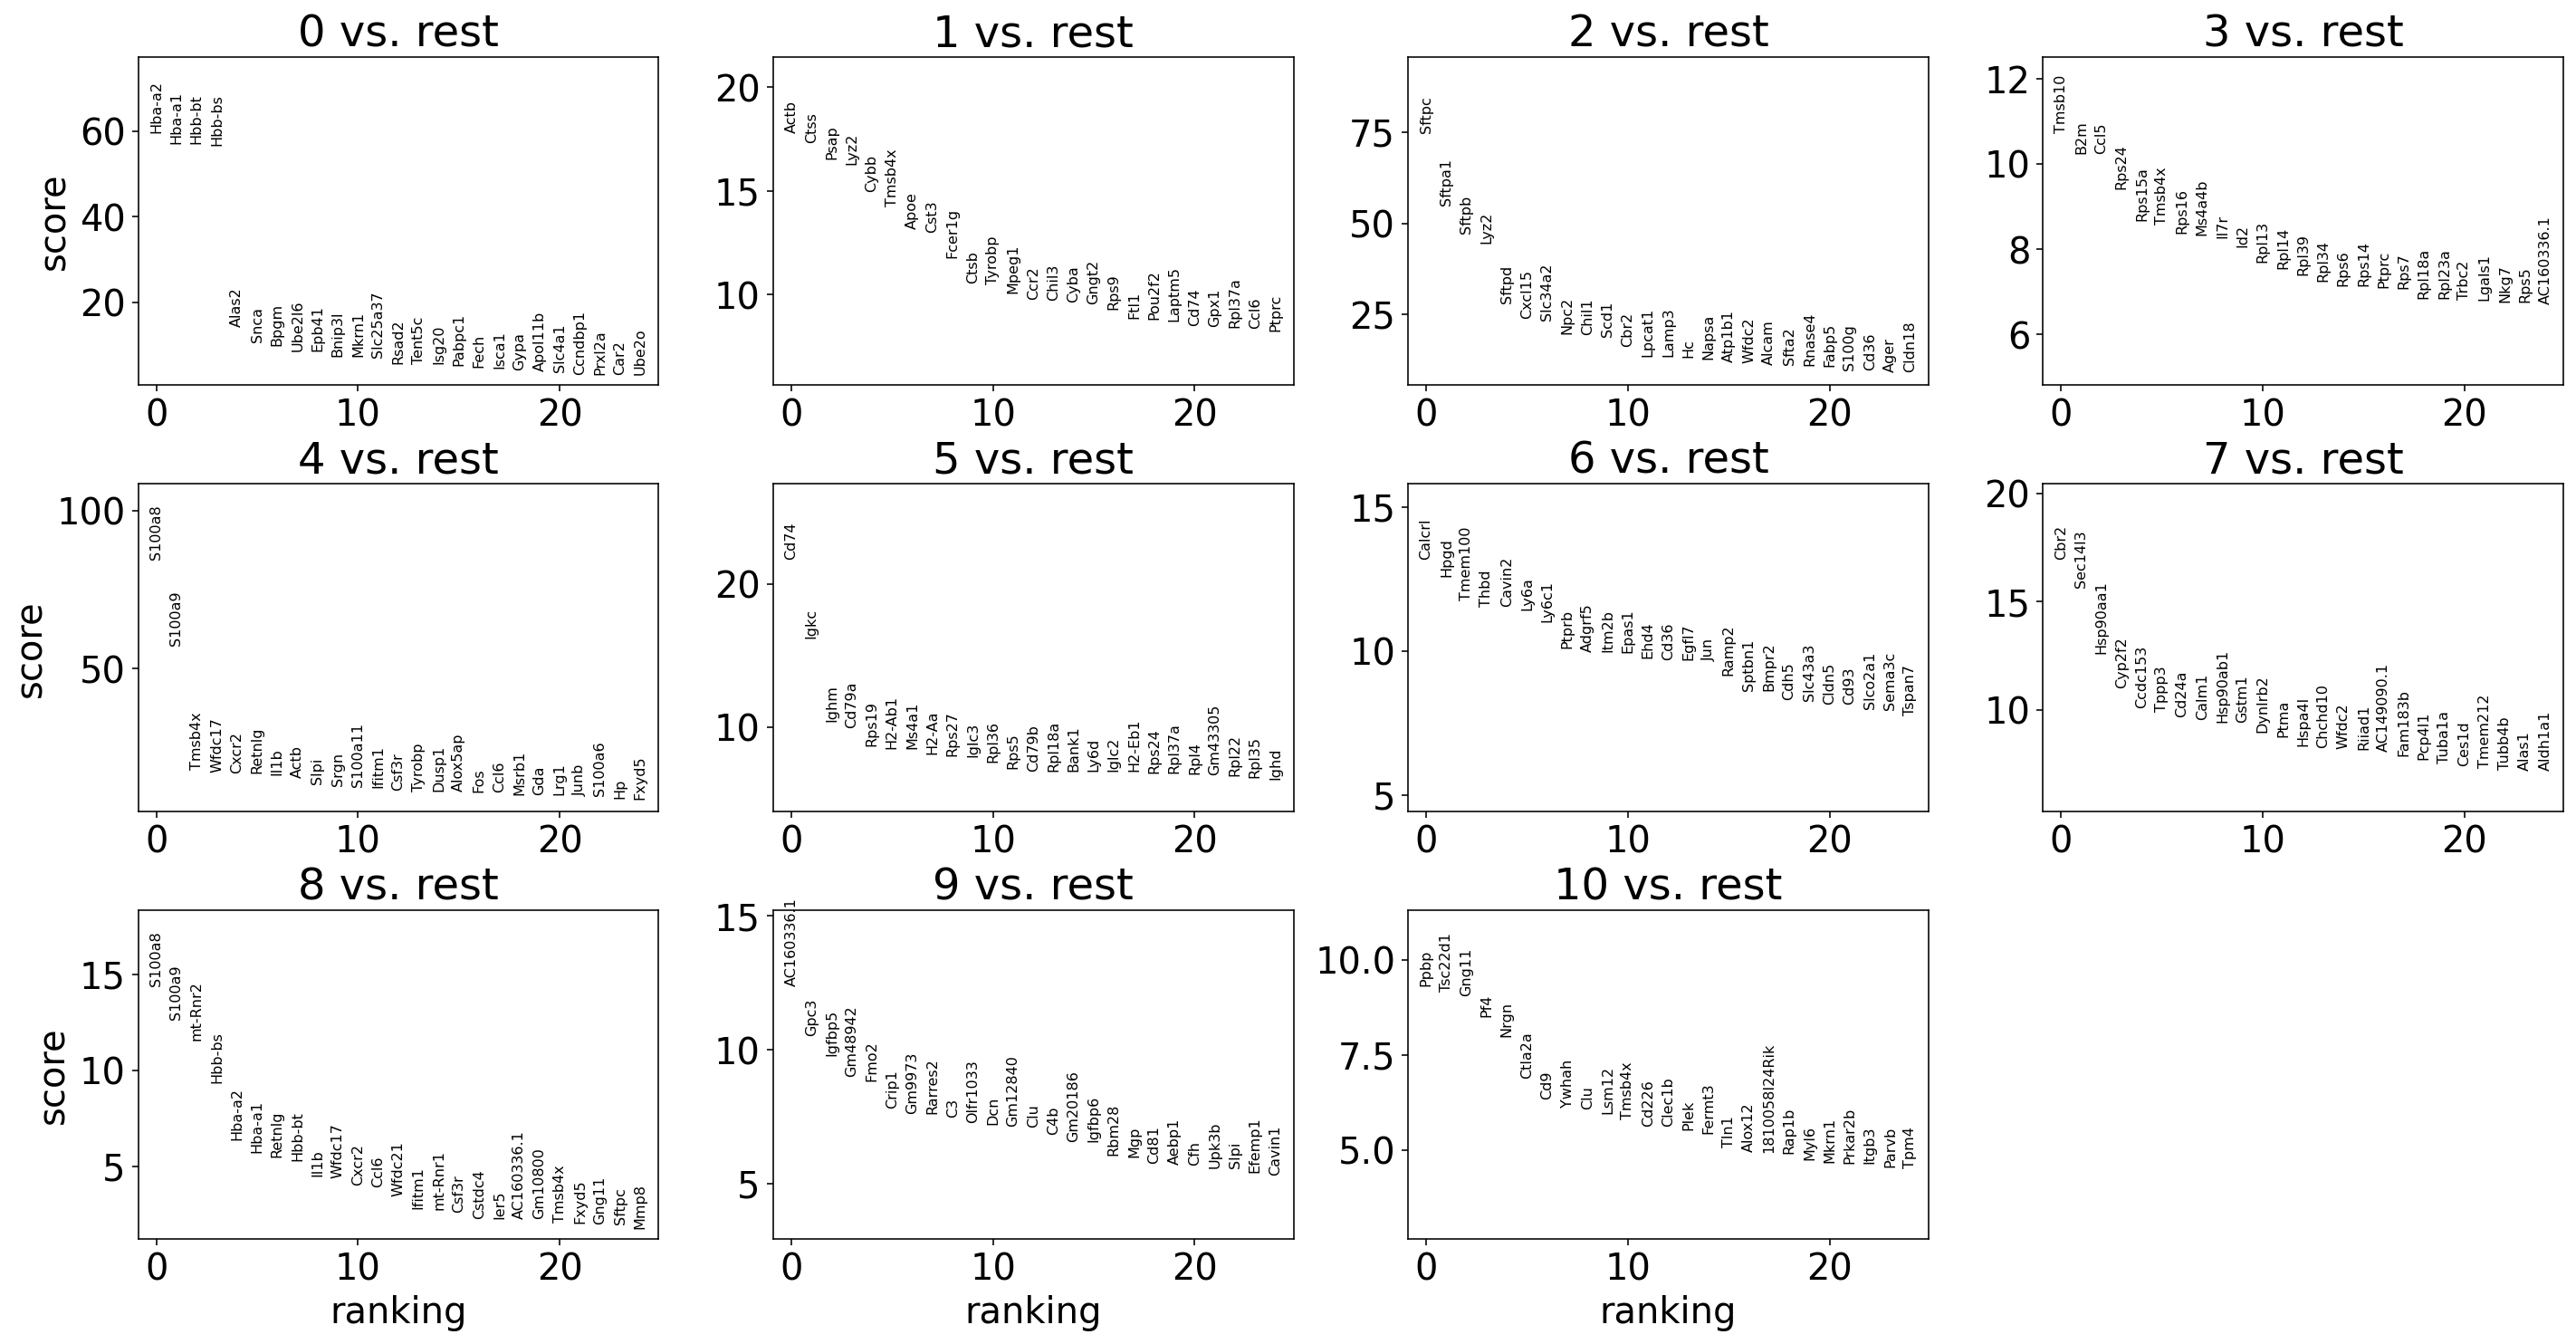

In [40]:
sc.tl.rank_genes_groups(data, 'leiden', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

An alternative to the parametric t-test is the non-parametric [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test.

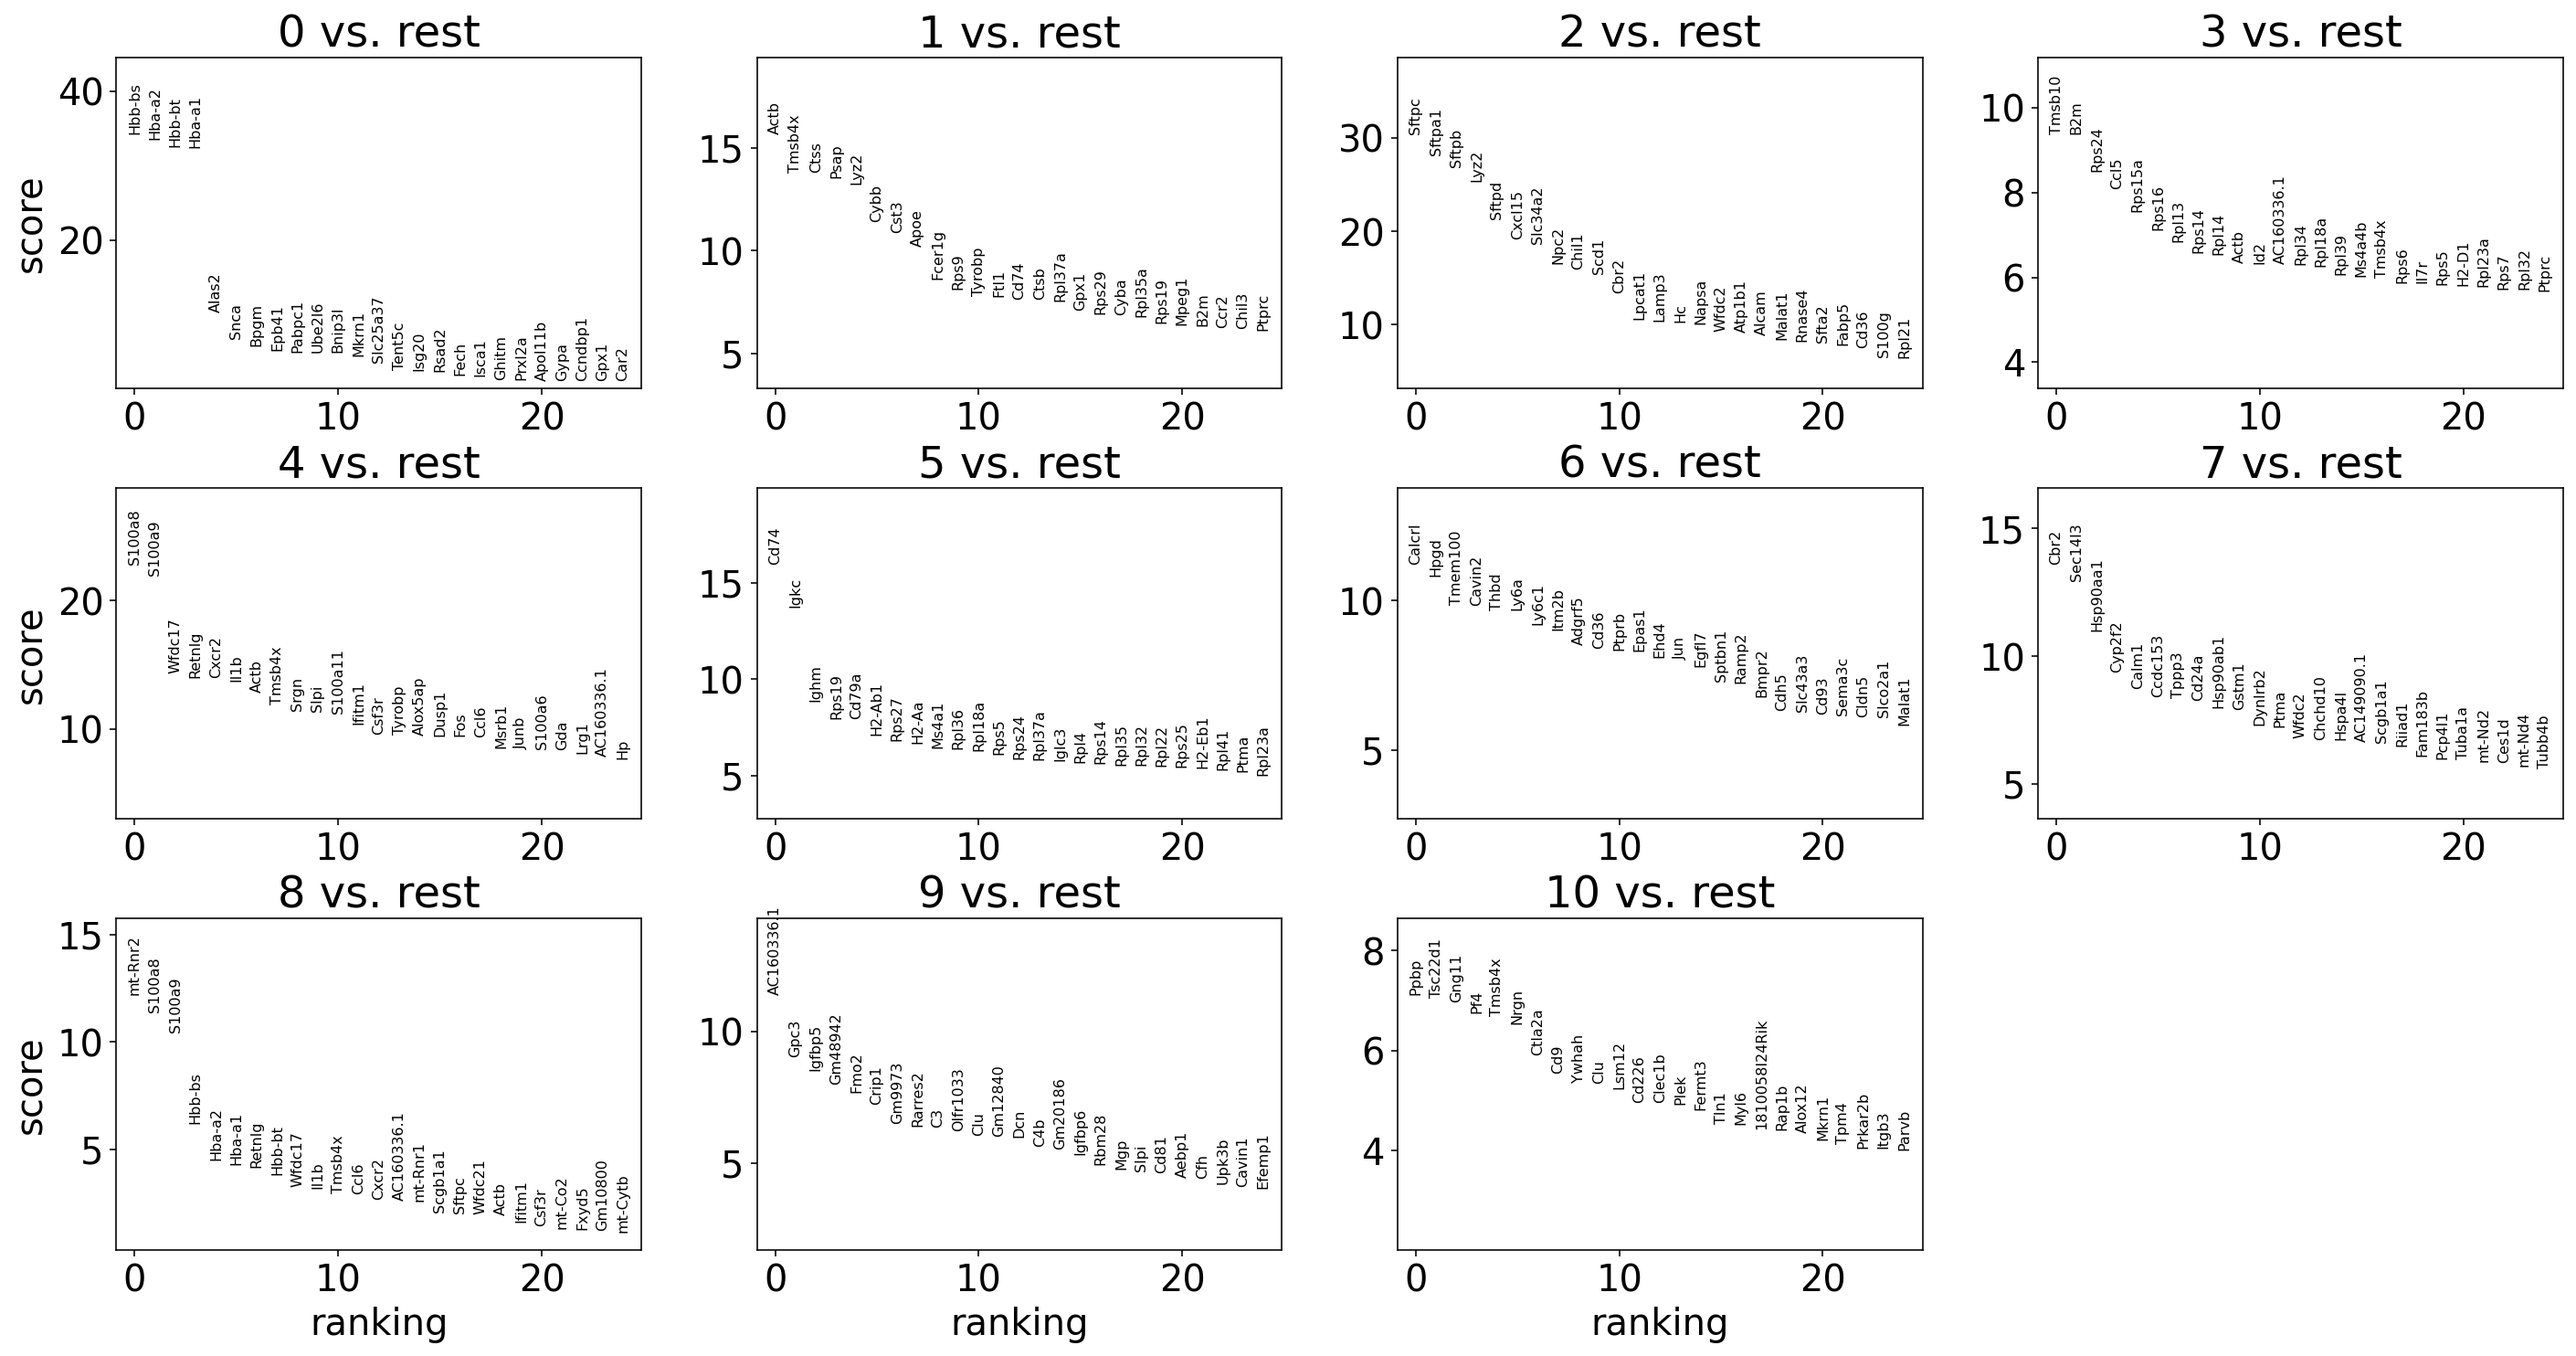

In [41]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

As an alternative, genes can be ranked using logistic regression (see [Natranos et al. (2018)](https://doi.org/10.1101/258566)).

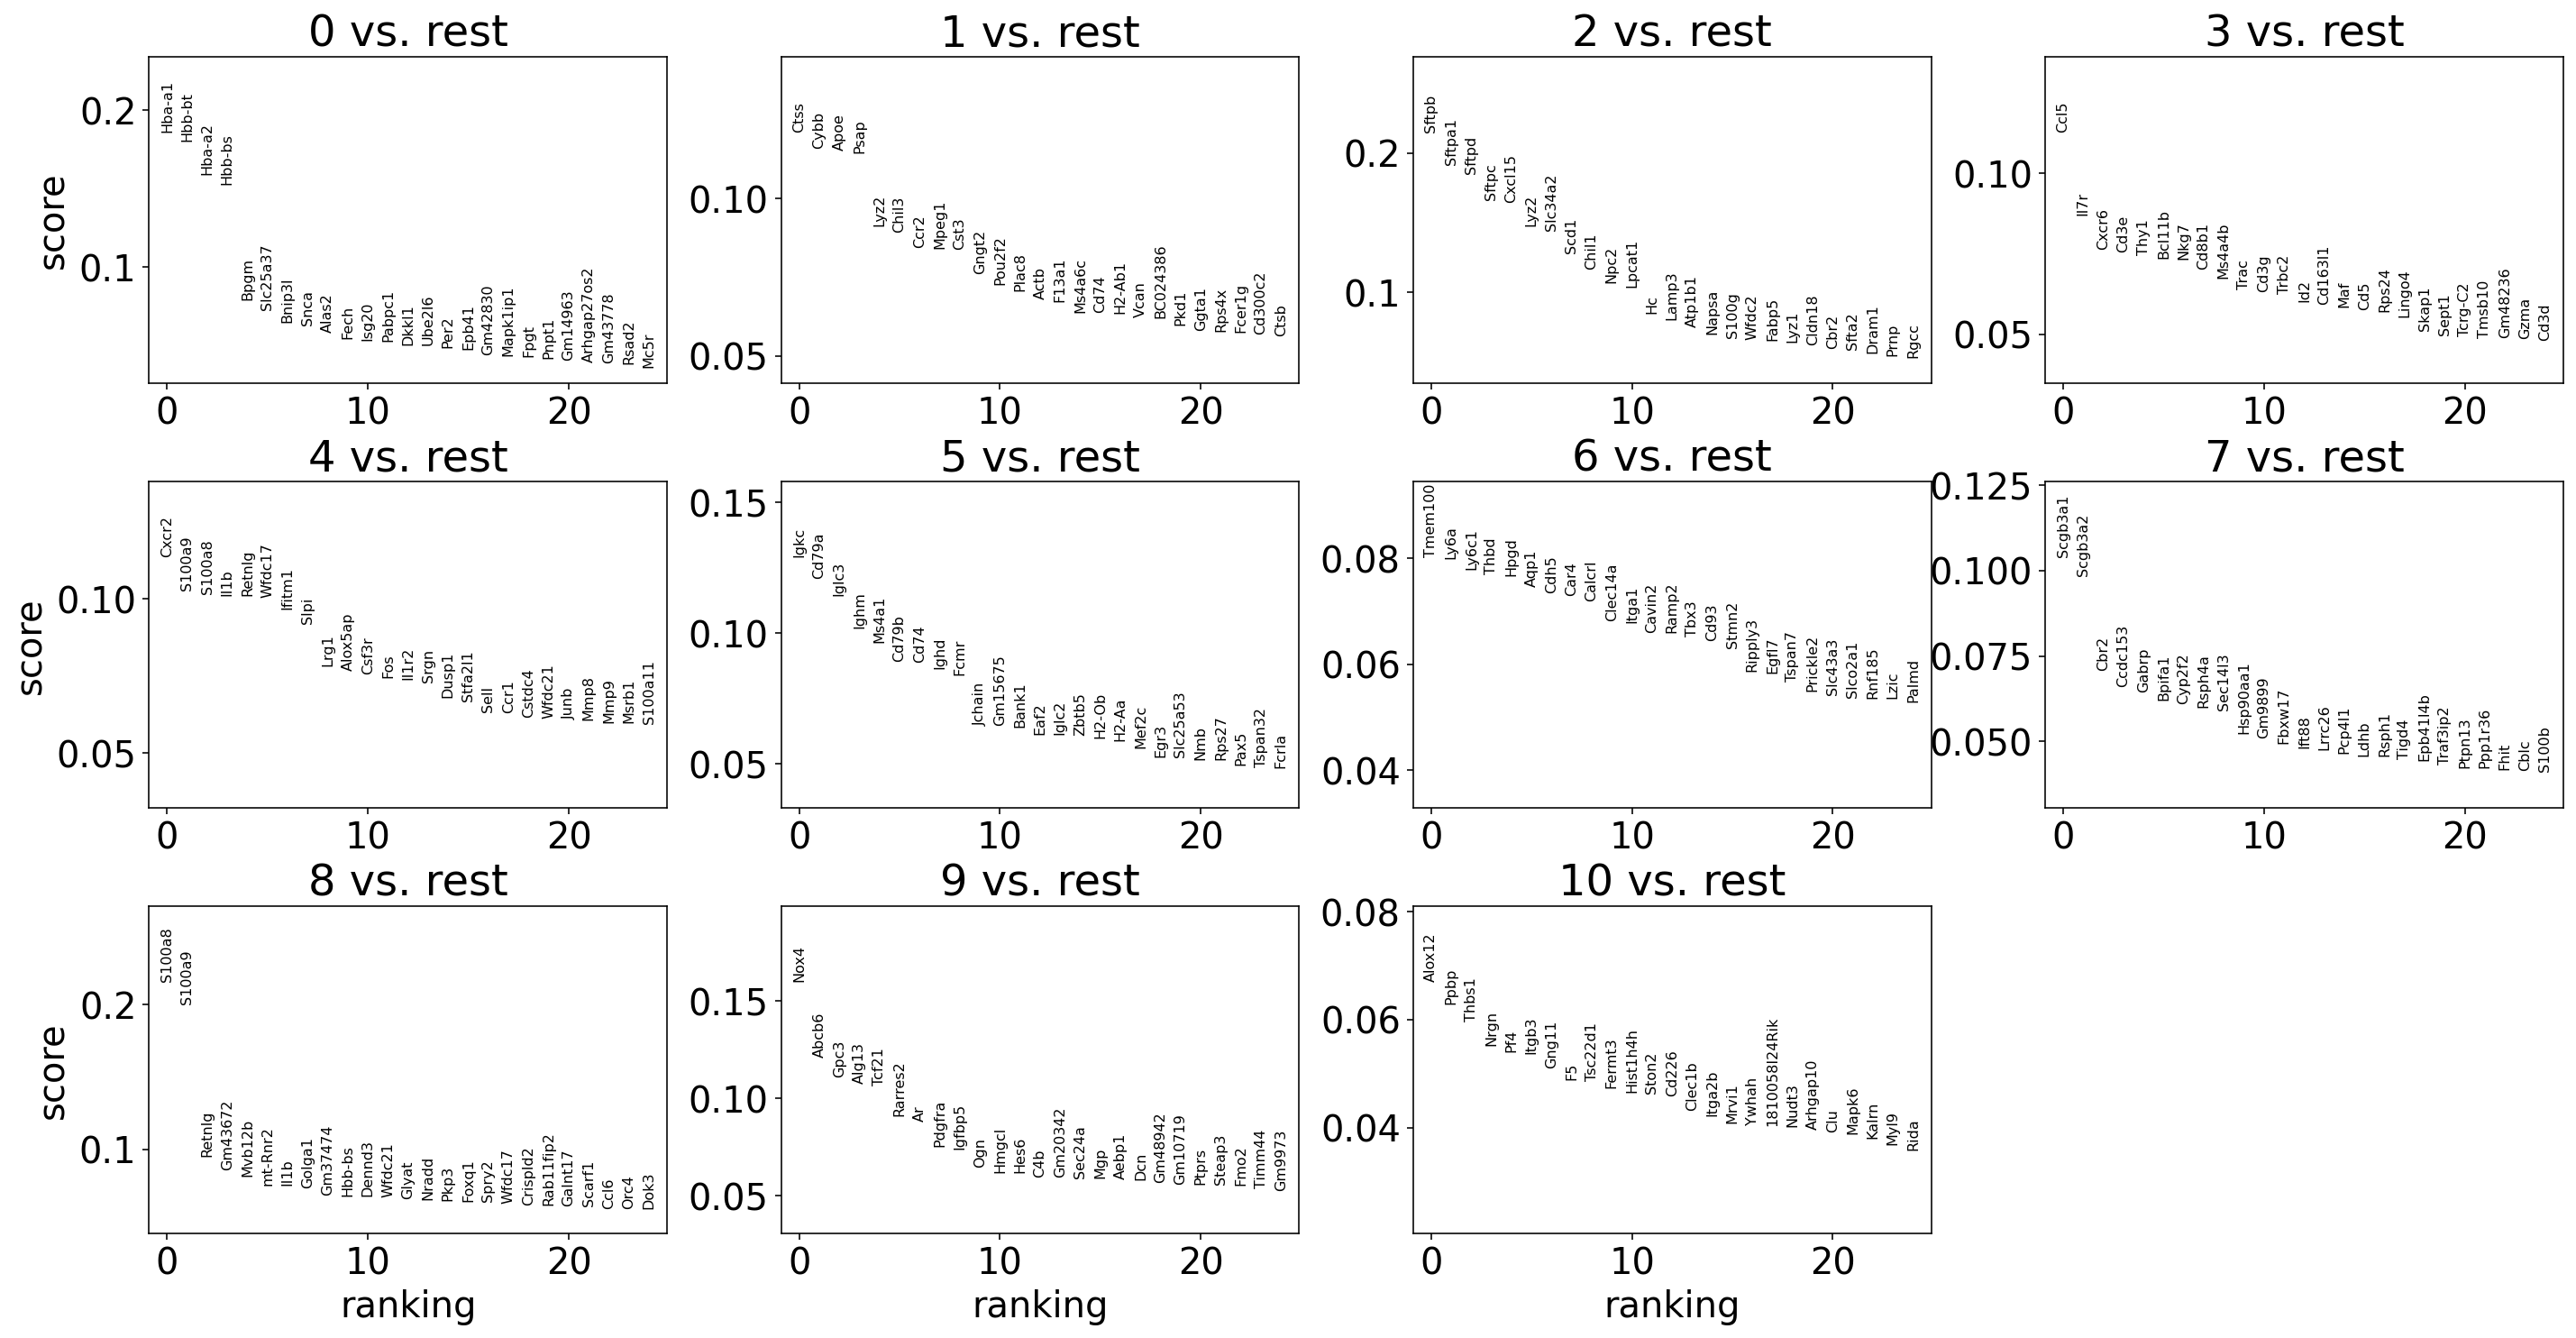

In [42]:
sc.tl.rank_genes_groups(data, 'leiden', method='logreg')
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

In [0]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")

Show the 10 top ranked genes per cluster in a dataframe.

In [44]:
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(10)

0       1        2       3  ...         7        8           9       10
0  Hbb-bs    Actb    Sftpc  Tmsb10  ...      Cbr2  mt-Rnr2  AC160336.1     Ppbp
1  Hba-a2  Tmsb4x   Sftpa1     B2m  ...   Sec14l3   S100a8        Gpc3  Tsc22d1
2  Hbb-bt    Ctss    Sftpb   Rps24  ...  Hsp90aa1   S100a9      Igfbp5    Gng11
3  Hba-a1    Psap     Lyz2    Ccl5  ...    Cyp2f2   Hbb-bs     Gm48942      Pf4
4   Alas2    Lyz2    Sftpd  Rps15a  ...     Calm1   Hba-a2        Fmo2   Tmsb4x
5    Snca    Cybb   Cxcl15   Rps16  ...   Ccdc153   Hba-a1       Crip1     Nrgn
6    Bpgm    Cst3  Slc34a2   Rpl13  ...     Tppp3   Retnlg      Gm9973   Ctla2a
7   Epb41    Apoe     Npc2   Rps14  ...     Cd24a   Hbb-bt     Rarres2      Cd9
8  Pabpc1  Fcer1g    Chil1   Rpl14  ...  Hsp90ab1   Wfdc17          C3    Ywhah
9  Ube2l6    Rps9     Scd1    Actb  ...     Gstm1     Il1b    Olfr1033      Clu

[10 rows x 11 columns]

Get a table with the scores and groups.

In [0]:
genes = pd.DataFrame(data.uns['rank_genes_groups']['names']).to_numpy()
pvals = pd.DataFrame(data.uns['rank_genes_groups']['pvals']).to_numpy()

In [0]:
unique = np.unique(data.obs.leiden.values.astype(int)).astype(str)
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])

In [0]:
for un, u in enumerate(unique):
    g = genes[:,un]
    p = pvals[:,un]
    markers_gene.loc[u]["gene_name"]  = g.tolist()
    markers_gene.loc[u]["p_value"] = p.tolist()

In [0]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()
markers_gene = markers_gene.rename(columns={"index":'leiden'})

In [49]:
markers_gene.drop_duplicates(["leiden"]) # just showing the top candidate per cluster

leiden   gene_name       p_value
0         0      Hbb-bs  2.81595e-257
100       1        Actb    2.1883e-55
200       2       Sftpc  2.74208e-203
300       3      Tmsb10   6.34479e-21
400       4      S100a8  2.60978e-115
500       5        Cd74   3.14078e-57
600       6      Calcrl   3.44092e-29
700       7        Cbr2   4.64093e-42
800       8     mt-Rnr2   3.44227e-34
900       9  AC160336.1   5.39398e-30
1000     10        Ppbp   1.12025e-12

In [0]:
def vplot_de(x, unique, specific_gene, specific_cluster, ax):
    unique = unique.astype(str)
    labels = unique
    lidx = np.arange(1, len(labels)+1)  # the label locations
    midx = np.where(unique==specific_cluster)[0][0]
    
    
    parts = ax.violinplot(x, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(parts['bodies']):
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        if pcidx == midx:
            pc.set_facecolor('#D43F3A')
            
    mean = [np.mean(i) for i in x]
    ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)
    
    ax.set_ylabel("$log(CPM + 1)$".format(specific_gene))
    ax.set_xticks(lidx)
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_title("{} gene in cluster {}".format(specific_gene, specific_cluster))
    
    return ax

In [0]:
specific_cluster = markers_gene.drop_duplicates(["leiden"])["leiden"].values
specific_gene = markers_gene.drop_duplicates(["leiden"])["gene_name"].values

In [52]:
unique

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
      dtype='<U21')

### Plot one cluster, gene pair

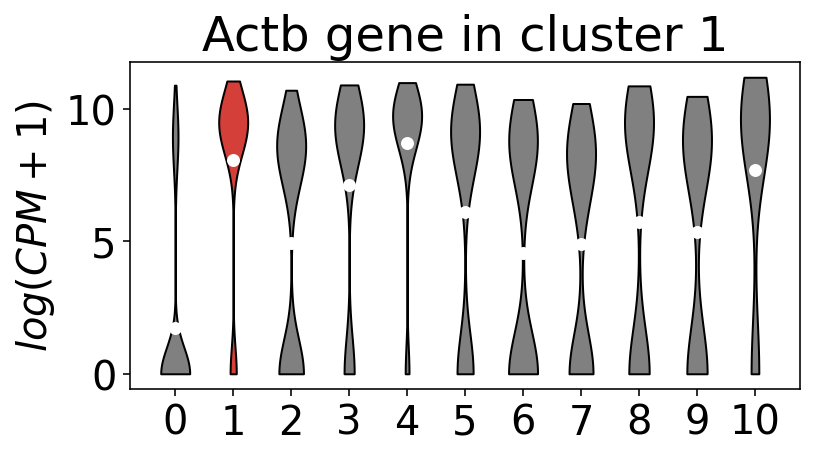

In [53]:
fig, ax = plt.subplots(figsize=(6, 3))

spec_c = specific_cluster[1]
spec_g = specific_gene[1]

x = []
for c in unique:
    x.append(nd(data[data.obs.leiden==str(c)][:,data.var.gene_name==spec_g].layers["log1p"].todense()).tolist())
    
vplot_de(x, unique, spec_g, spec_c, ax=ax)

ax.set_ylabel("$log(CPM+1)$")

plt.show()

### Plot all cluster gene pairs

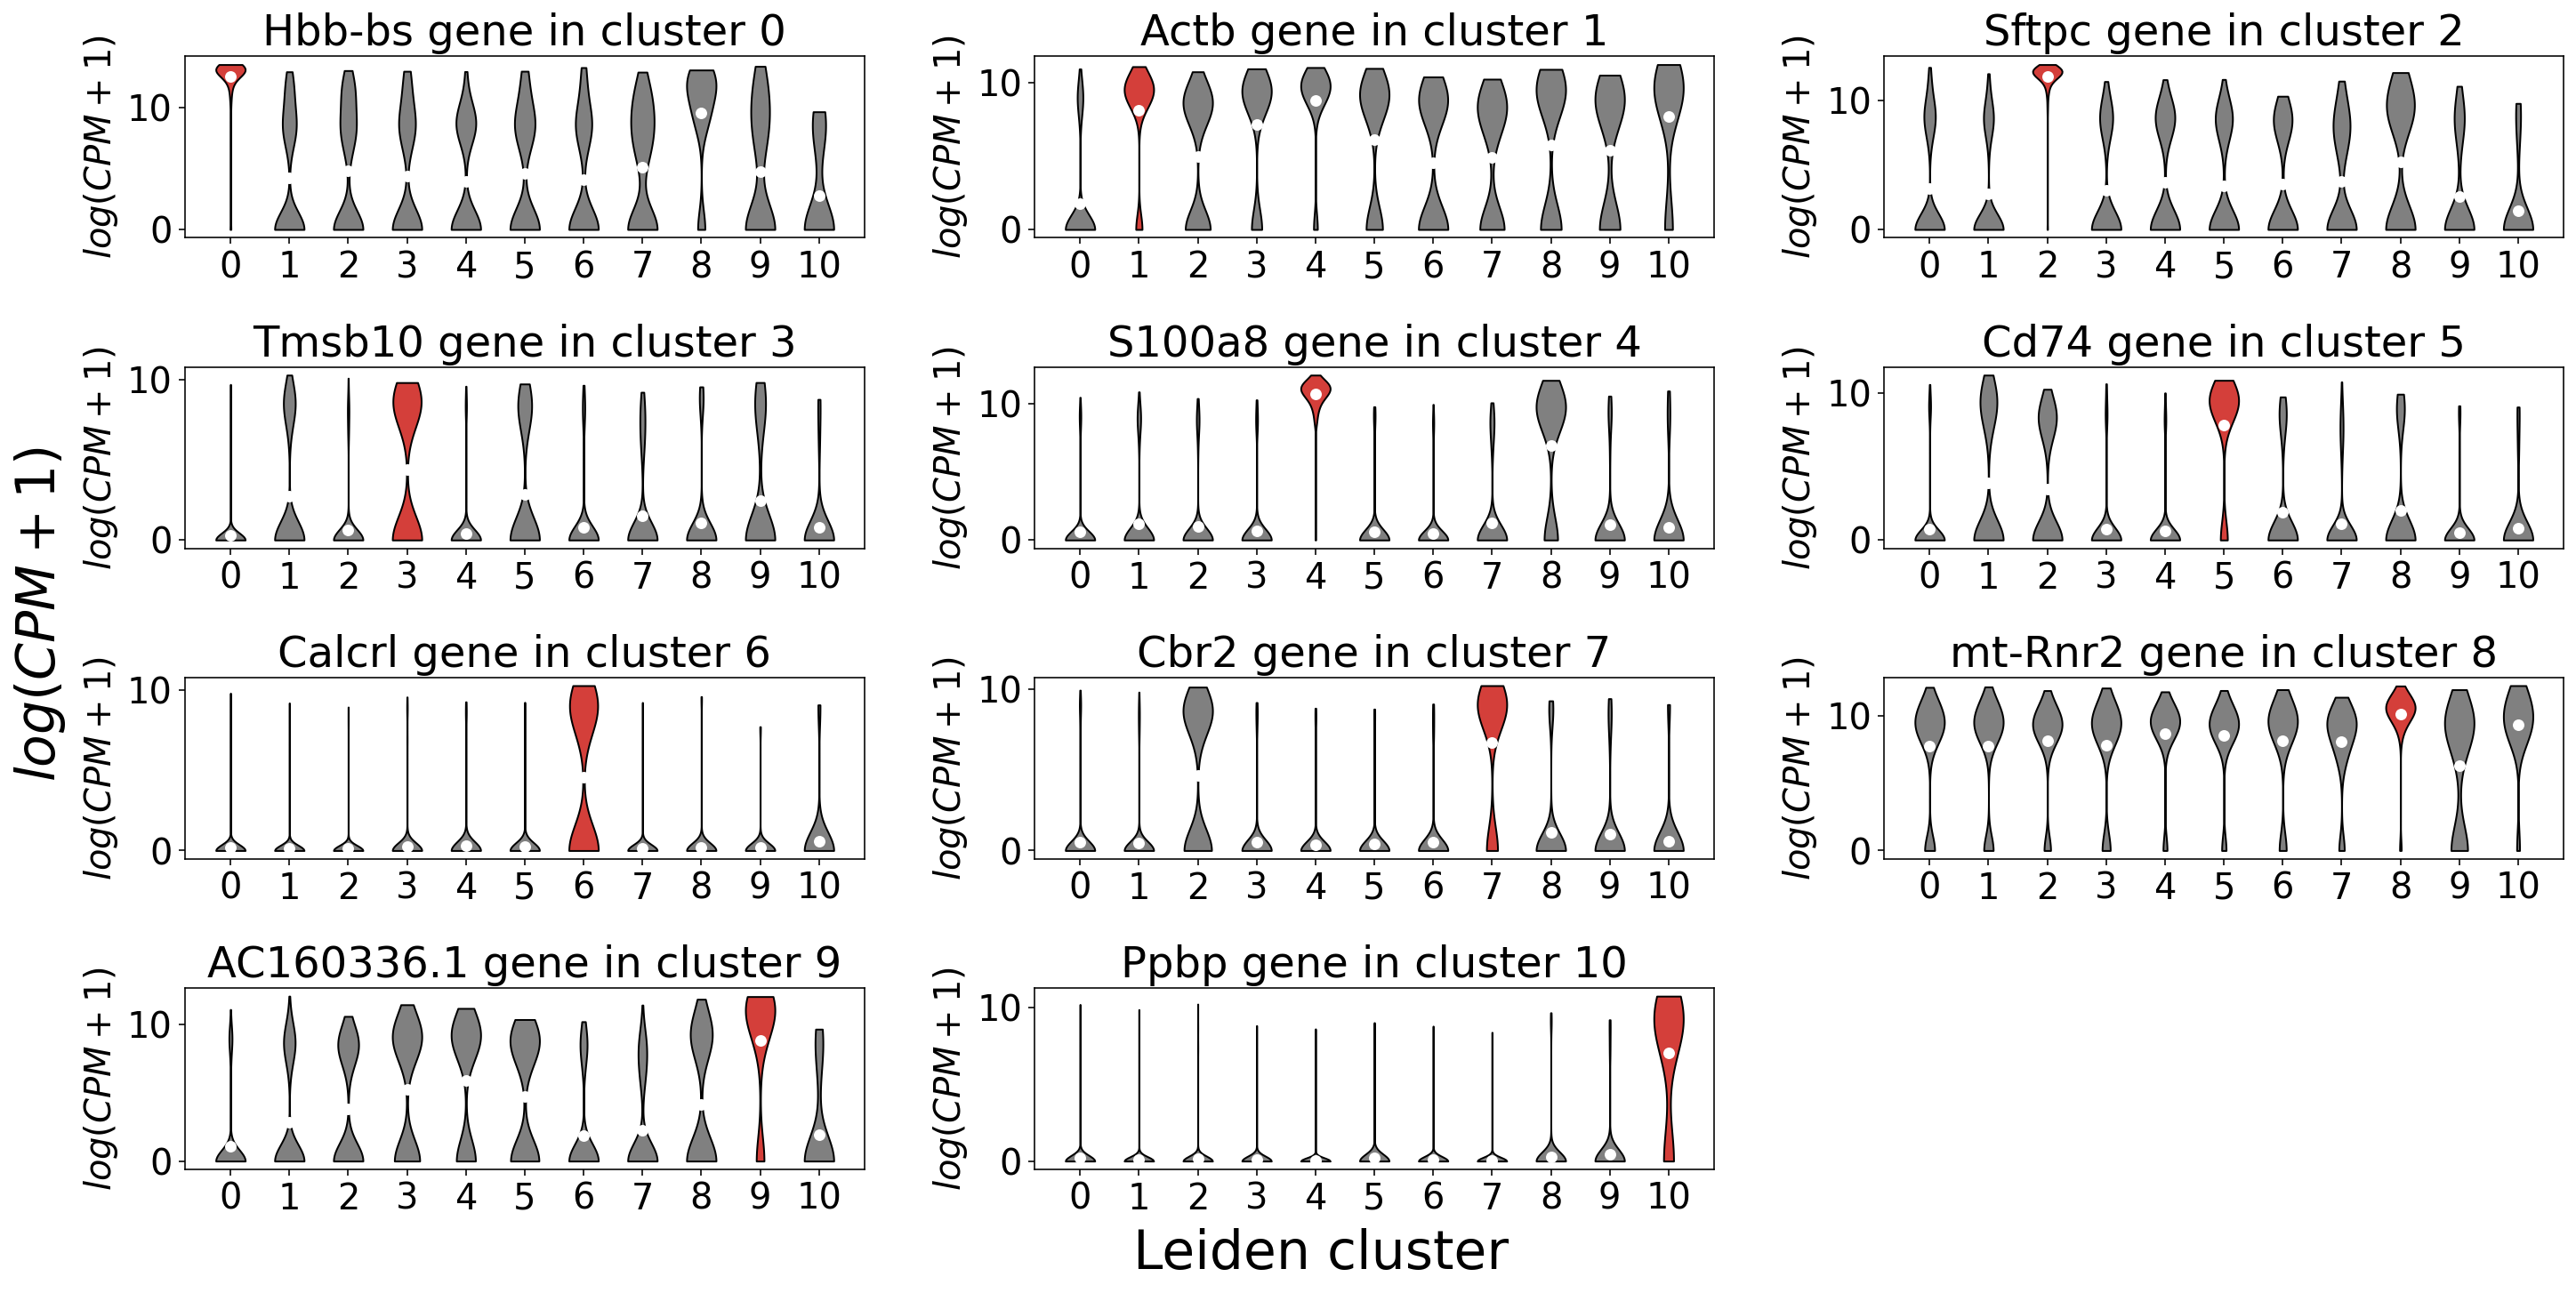

In [54]:
length = len(specific_cluster)*5
height = 3

fig, ax = plt.subplots(figsize=(20,10), ncols = 3, nrows=4)

axs = trim_axs(ax, len(specific_cluster))

for sn, (spec_c, spec_g) in enumerate(zip(specific_cluster, specific_gene)):
    x = []
    for c in unique:
        x.append(nd(data[data.obs.leiden==str(c)][:,data.var.gene_name==spec_g].layers["log1p"].todense()).tolist())
        
    vplot_de(x, unique, spec_g, spec_c, ax=axs[sn])
    
    
fig.text(0.5, 0, 'Leiden cluster', ha='center', va='center', fontsize=30)
fig.text(0, 0.5, '$log(CPM +1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.tight_layout()

plt.show()

# Visualize expression patterns of a specific marker gene

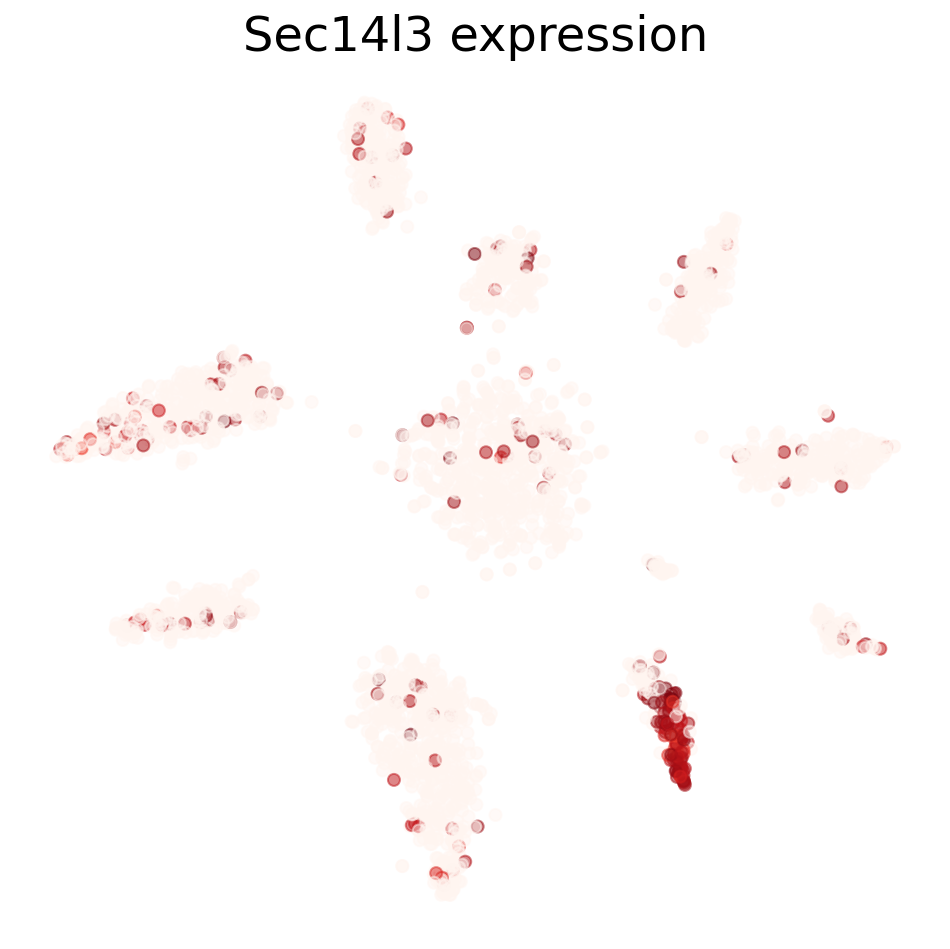

In [55]:
gene = "Sec14l3"

fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene])

ax.scatter(x, y, c = c, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax.set_title("{} expression".format(gene))
plt.tight_layout()
plt.show()

## Annotate clusters

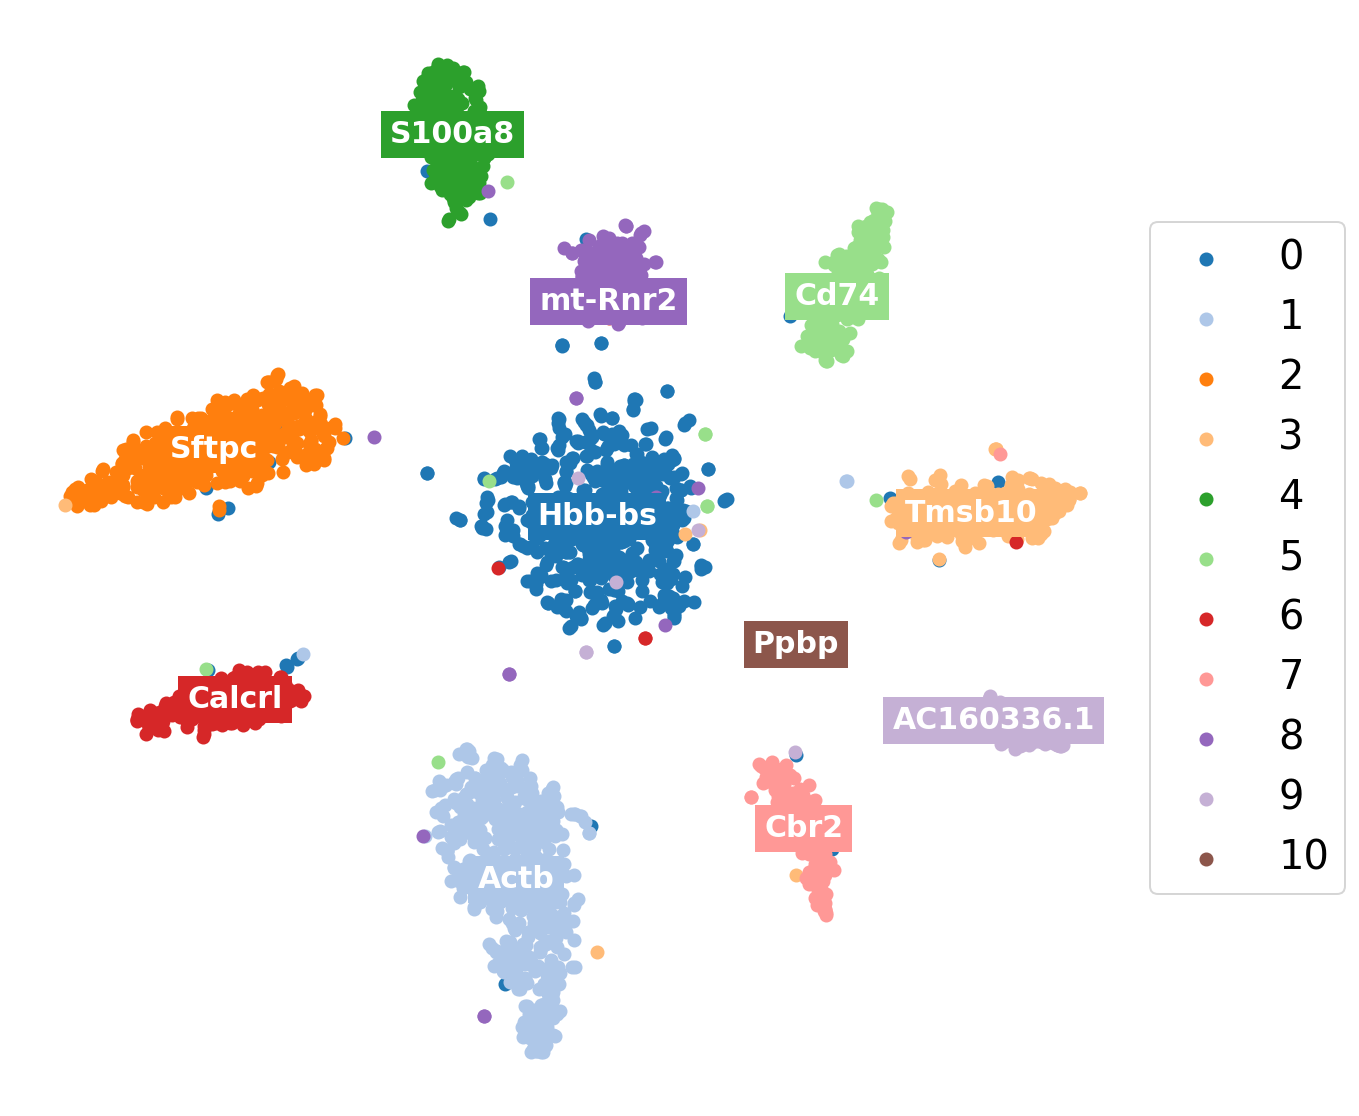

In [56]:
fig, ax = plt.subplots(figsize=(10,10))

c = np.unique(data.obs["leiden"].values.astype(int)).astype(str)
cmap = cm.get_cmap("tab20")

for idx, (cluster, gene) in enumerate(zip(c, specific_gene)):
    XX = data[data.obs.leiden == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(gene, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

In [0]:
top_idx = [np.where(i == data.var.gene_name.values)[0][0] for i in specific_gene]

In [0]:
mat = data.layers["norm"].todense()
obs = data.obs
var = data.var

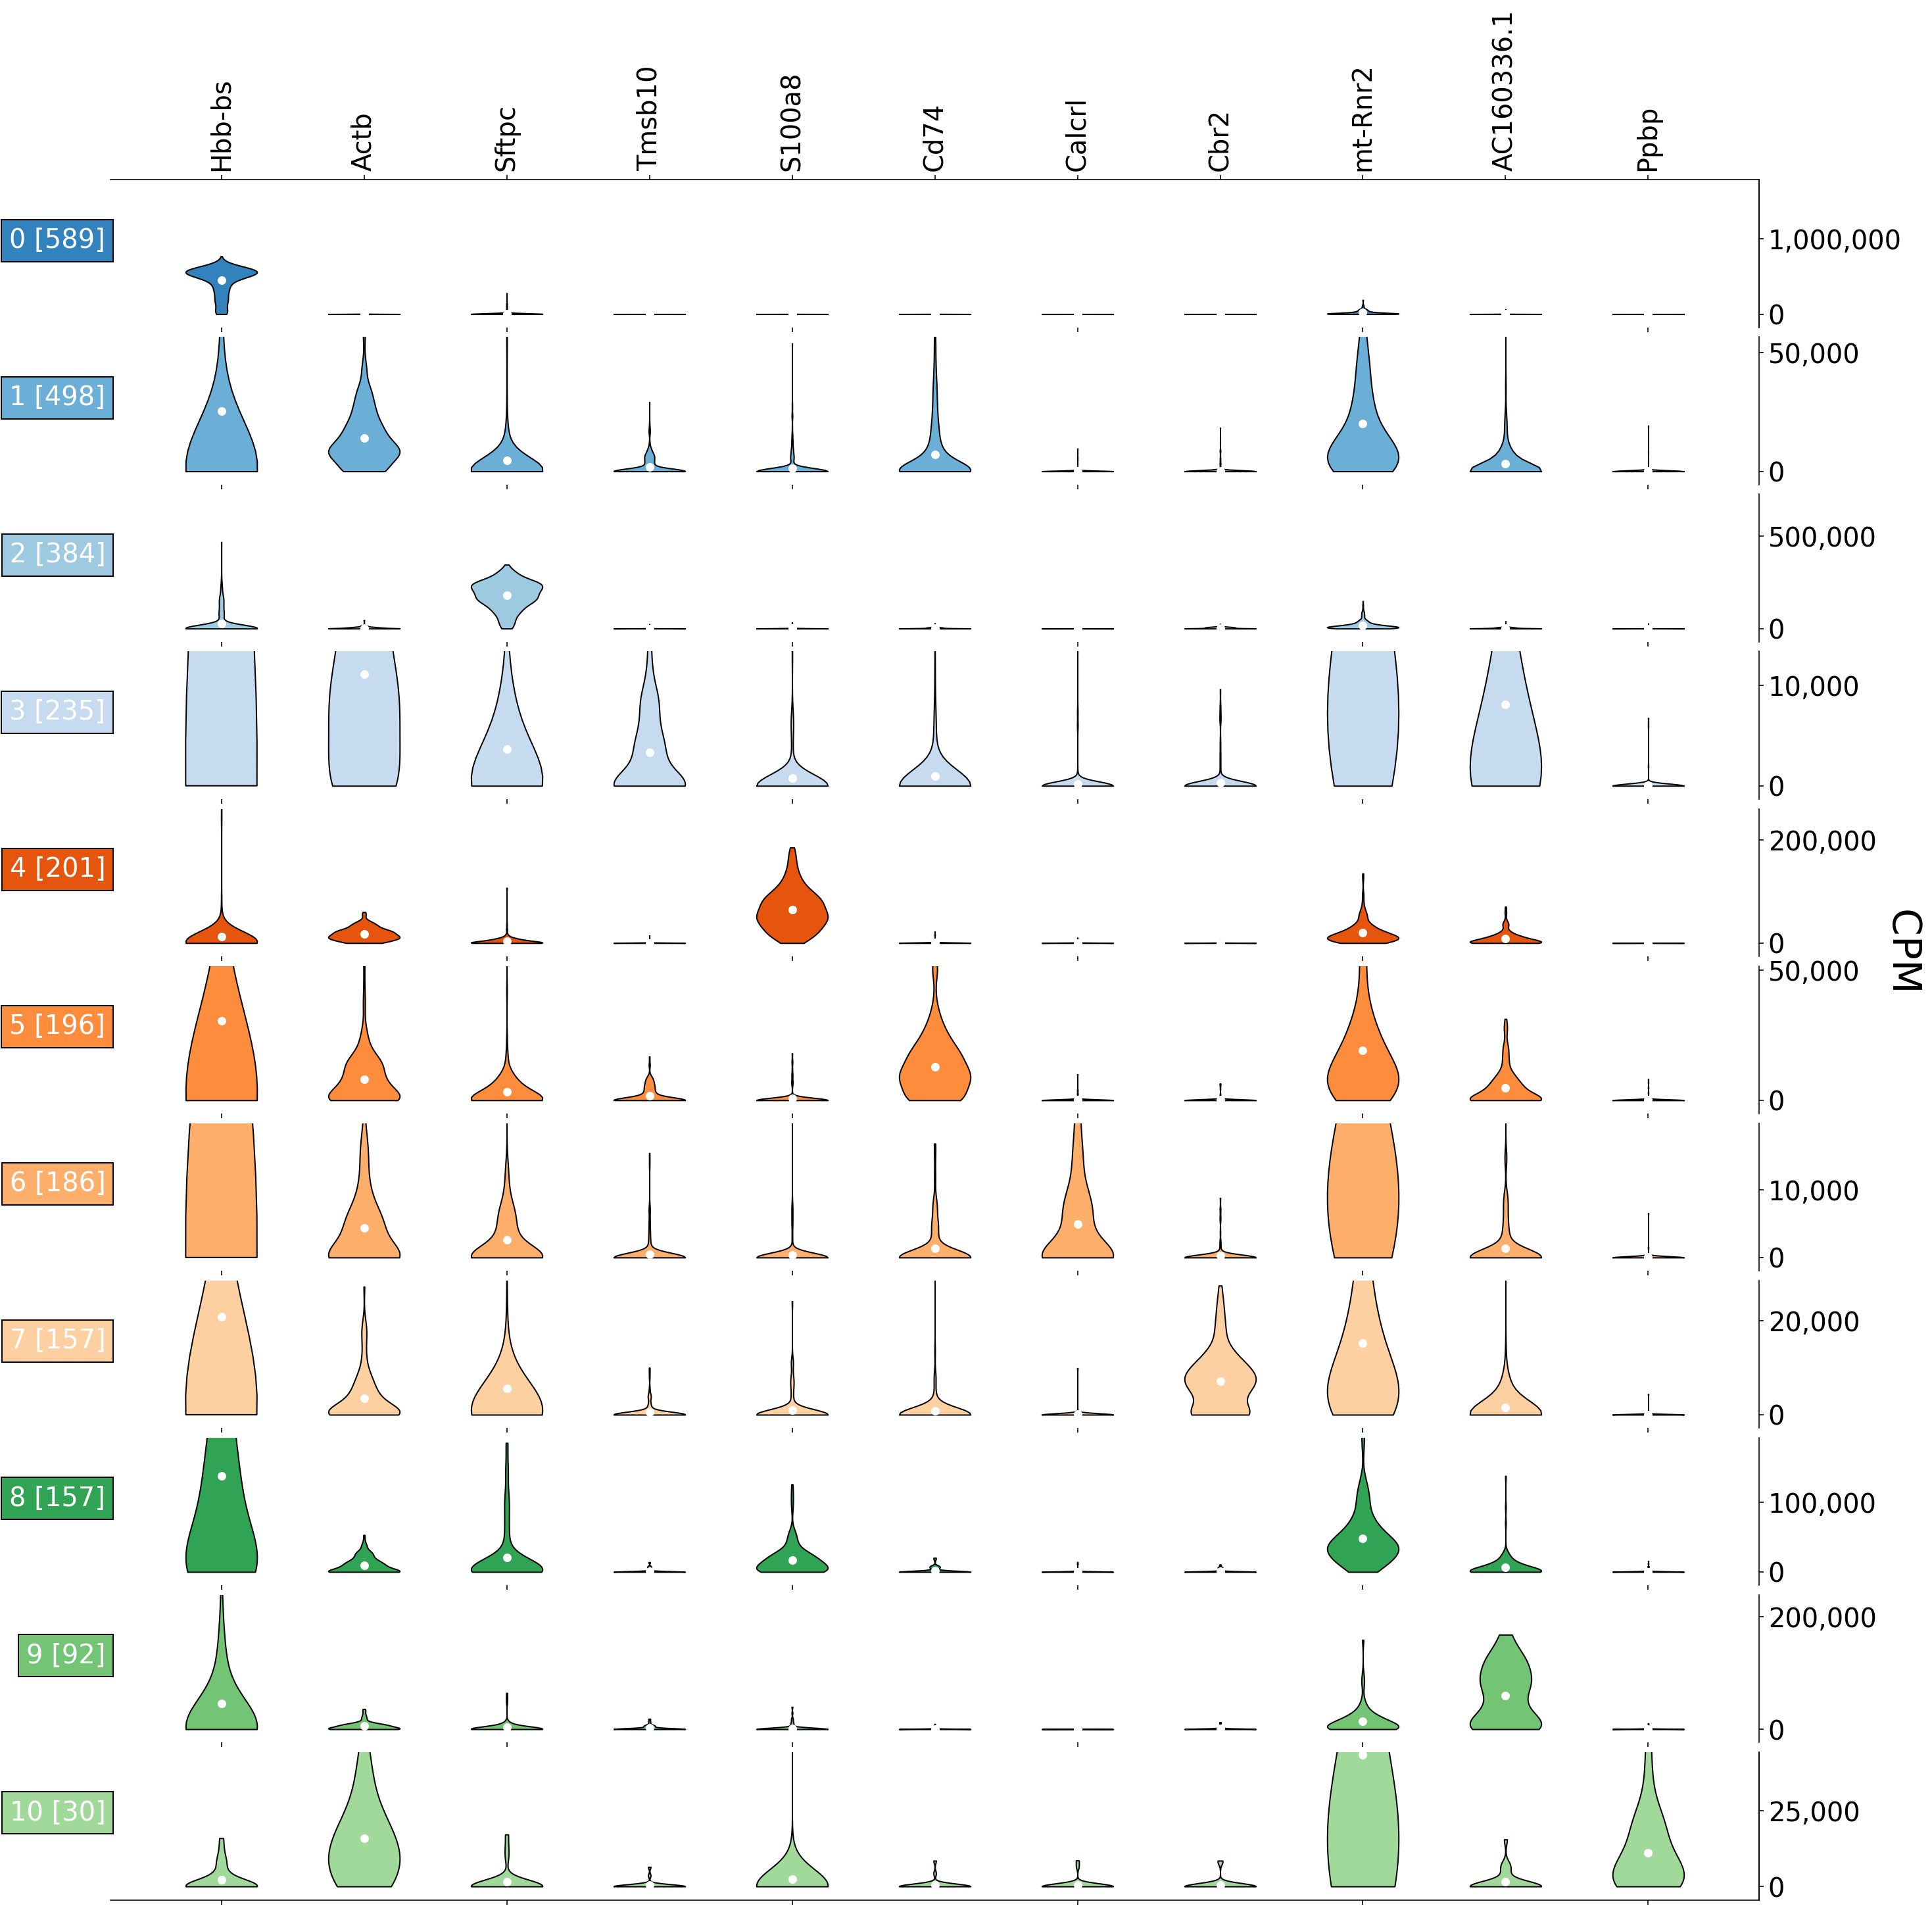

In [59]:
fig, axs = plt.subplots(figsize=(20,20), nrows=len(unique))
fig.subplots_adjust(wspace=0, hspace=0)


labels = specific_gene
lidx = np.arange(0, len(top_idx), 1)
means = []

for cidx, (c, ax) in enumerate(zip(unique, axs)):
    tmp_mat = mat[obs.leiden==str(c),:]
    
    x = tmp_mat[:,top_idx]
    means.append(nd(np.median(x,axis=0)))

    v = ax.violinplot(x.T.tolist(), showmedians=False, showextrema=False, positions=lidx)

    for pcidx, pc in enumerate(v['bodies']):
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_facecolor(cm.tab20c(cidx))
        

    means = [np.mean(i) for i in x.T]
    ax.scatter(lidx, means, marker='o', color='white', s=30, zorder=3)
 
    if cidx==0:
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(lidx)
        ax_top.set_xticklabels(labels, rotation=90, ha="center")
        ax_top.spines["top"].set_visible(True)
        ax_top.spines["left"].set_visible(False)
        ax_top.spines["bottom"].set_visible(False)
    if cidx == len(unique)-1:
        ax_bot = ax.twiny()
        ax_bot.set_xticks([])
        ax_bot.set_xticklabels([])
        ax_bot.spines["top"].set_visible(False)
        ax_bot.spines["left"].set_visible(False)
        ax_bot.spines["bottom"].set_visible(True)

    ax.set_xticklabels("")
    ax.yaxis.tick_right()
    ax.set_ylabel("{} [{:,}]".format(c, x.shape[0]), color="white",rotation="horizontal", ha="right",bbox=dict(boxstyle="square",ec="black",fc=cm.tab20c(cidx)))
    

    
    lim = nd(x.mean(axis=0))[cidx]*4
    
    ax.set_ylim(-lim*0.1, lim)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

        
    
    

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.text(1, 0.5, 'CPM ', ha='center', va='center', rotation=270, fontsize=30)
plt.show()

Note that as a result of the analysis the adata object has accumulated several annotations:

In [60]:
data

AnnData object with n_obs × n_vars = 2725 × 12515 
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter', 'leiden'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'pass_gene_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'leiden', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_tsne', 'X_nca', 'X_nca_tsne'
    layers: 'raw', 'norm', 'log1p', 'scale'

In [61]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

27.65 minutes


**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_python.ipynb).